# Place Cell Analyses

Analyze TH data for place cells.

In [1]:
%config Completer.use_jedi = False

In [2]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pynwb import NWBHDF5IO

from spiketools.spatial.occupancy import (compute_nbins, compute_occupancy, 
                                          compute_bin_edges, compute_bin_assignment,
                                          compute_bin_firing, normalize_bin_firing)
from spiketools.spatial.utils import get_pos_ranges, get_bin_width
from spiketools.spatial.information import compute_spatial_information
from spiketools.stats.shuffle import shuffle_spikes
from spiketools.stats.permutations import compute_surrogate_stats
from spiketools.plts.space import plot_positions, plot_heatmap
from spiketools.plts.stats import plot_surrogates
from spiketools.plts.utils import make_axes
from spiketools.plts.annotate import color_pval
from spiketools.utils import set_random_seed
from spiketools.utils.data import get_range, restrict_range, get_value_by_time_range
from spiketools.utils.trials import epoch_data_by_range

In [3]:
import seaborn as sns
sns.set_context('talk')

In [4]:
import sys
sys.path.append('../code')
from analysis import get_spike_positions
from place import get_trial_place, compute_place_bins, create_df_place, fit_anova_place

## Settings

In [5]:
# Set random seed, for consistency shuffling
set_random_seed(101)

In [6]:
# Define the base data folder
#data_folder = Path('/Users/Claire_han/Documents/Data/JacobsLab/TH')
data_folder = Path('/Users/tom/Documents/Data/JacobsLab/TH/')

In [7]:
# Define subject information
task = 'THF'
subj = 'wv002'
session = 1

In [8]:
# Define bins to use
#bins = [7, 21]
#bins = [9, 12]
bins = [6, 10]
n_bins = compute_nbins(bins)

# Define occupancy settings: minimum required occupancy (in seconds) & speed threshold
min_occ = 1
speed_thresh = 5e-6

In [9]:
# Shuffle Settings
shuffle_approach = 'CIRCULAR'
# shuffle_approach = 'BINCIRC'
n_surrogates = 10

if shuffle_approach == 'CIRCULAR':
    shuffle_kwargs = {}
if shuffle_approach == 'BINCIRC':
    shuffle_kwargs = {'shuffle_min' : 20000}

In [10]:
# Set example unit to analyze
uind = 3

In [11]:
# Set which analysis method to run
METHOD = 'INFO'

## Load Data

In [12]:
# Define expected NWB file name & full path
file_name = '_'.join([task, subj, 'session_' + str(session)]) + '.nwb'
full_path = data_folder / 'NWB' / file_name

In [13]:
# Load NWB file
io = NWBHDF5IO(str(full_path), 'r')
nwbfile = io.read()

#### Extract Time Definitions

In [14]:
# Get the navigation time ranges
nav_starts = nwbfile.trials.navigation_start[:]
nav_stops = nwbfile.trials.navigation_stop[:]

#### Extract Position Data

In [15]:
# Extract the position data
ptimes = nwbfile.acquisition['position']['player_position'].timestamps[:]
positions = nwbfile.acquisition['position']['player_position'].data[:].T
stimes = nwbfile.processing['position_measures']['speed'].timestamps[:]
speed = nwbfile.processing['position_measures']['speed'].data[:]

In [16]:
# Get boundary ranges
x_boundary = nwbfile.acquisition['boundaries']['x_range'].data[:]
z_boundary = nwbfile.acquisition['boundaries']['z_range'].data[:]

# Add a buffer to the z-range (for tower transport)
z_boundary = z_boundary + np.array([-15, 15])

#### Extract Boundaries

In [17]:
# Collect together boundary ranges
area_range = [x_boundary, z_boundary]
print('X boundary range: ', x_boundary)
print('Z boundary range: ', z_boundary)

X boundary range:  [349.8549 419.8549]
Z boundary range:  [293.     424.3358]


#### Select position traces from navigation periods

In [18]:
# Get position data for navigation segments
ptimes_trials, positions_trials = epoch_data_by_range(ptimes, positions, nav_starts, nav_stops)
stimes_trials, speed_trials = epoch_data_by_range(stimes, speed, nav_starts, nav_stops)

In [19]:
# Recombine position data across selected navigation trials
ptimes = np.hstack(ptimes_trials)
positions = np.hstack(positions_trials)
stimes = np.hstack(stimes_trials)
speed = np.hstack(speed_trials)

#### Extract Spike Data

In [20]:
# Check the number of units & keep indices
n_units = len(nwbfile.units)
keep_inds = np.where(nwbfile.units.keep[:])[0]
n_keep = len(keep_inds)
print('Number of units: {}'.format(n_units))
print('Number to keep:  {}'.format(n_keep))

Number of units: 64
Number to keep:  54


In [21]:
# Extract spikes for a unit of interest
spikes = nwbfile.units.get_unit_spike_times(uind)

## Position Data

In [22]:
# Compute position ranges
x_range, z_range = get_pos_ranges(positions)

In [23]:
# Check ranges of positon
print('Position X-range:  {:1.2f} - {:1.2f} ({:1.2f})'.format(*x_range, x_range[1] - x_range[0]))
print('Position Z-range:  {:1.2f} - {:1.2f} ({:1.2f})'.format(*z_range, z_range[1] - z_range[0]))

Position X-range:  365.08 - 418.59 (53.51)
Position Z-range:  301.92 - 422.94 (121.02)


In [24]:
# Get position values for each spike
spike_xs, spike_ys = get_spike_positions(spikes, ptimes, positions, threshold=0.1)
spike_positions = np.array([spike_xs, spike_ys])

In [25]:
# Check binning
x_bin_edges, y_bin_edges = compute_bin_edges(positions, bins, area_range)

In [26]:
# Check bin sizes
print('Bin widths: {:1.2f}, {:1.2f}'.format(get_bin_width(x_bin_edges), get_bin_width(y_bin_edges)))

Bin widths: 11.67, 13.13


### Occupancy

In [27]:
# Collect settings for occupancy
occ_kwargs = {'minimum' : min_occ, 'area_range' : area_range, 'set_nan' : True}

In [28]:
# Compute occupancy
occ = compute_occupancy(positions, ptimes, bins, speed, speed_thresh, **occ_kwargs)

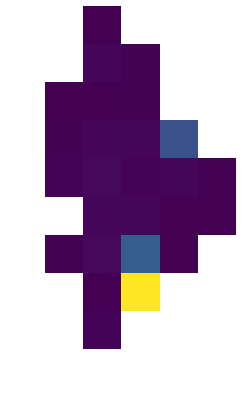

In [29]:
# Plot occupancy
plot_heatmap(occ, ignore_zero=False, figsize=(5, 7))

## Check spike locations

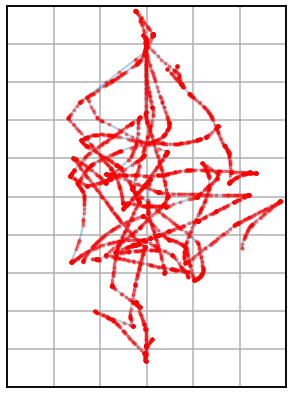

In [30]:
# Plot the map across all position traces (plotted per trial)
plot_positions(positions_trials, spike_positions,
               x_bins=x_bin_edges, y_bins=y_bin_edges,
               xlim=list(x_boundary), ylim=list(z_boundary),
               figsize=(5, 7))

## Compute Binned Spatial Firing

In [31]:
# Compute spatial bin assignments for each spike
x_binl, y_binl = compute_bin_assignment(spike_positions, x_bin_edges, y_bin_edges)

In [32]:
# Compute summary map of bin firing
bin_firing = compute_bin_firing(bins, x_binl, y_binl)

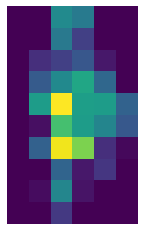

In [33]:
# Check the firing map
plot_heatmap(bin_firing)

In [34]:
# Normalize bin firing by occupancy
normed_bin_firing = normalize_bin_firing(bin_firing, occ)

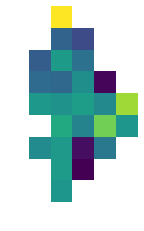

In [35]:
# Plot occupancy-normalized spatial firing
plot_heatmap(normed_bin_firing)

In [36]:
## TEMP - PER TRIAL

# Note check and maybe remove this.

In [37]:
# Get the number of trials
n_trials = len(nwbfile.trials)
print('Number of trials: {}'.format(n_trials))

# Set a trial index to get data for
t_ind = 5

Number of trials: 8


In [38]:
# Get the navigation time ranges
nav_starts_trial = nwbfile.trials.navigation_start[t_ind]
nav_stops_trial = nwbfile.trials.navigation_stop[t_ind]

In [39]:
# Get data for selected trial: trial positions, spikes, and spike positions
trial_times, trial_pos = get_value_by_time_range(ptimes, positions,
                                                 nav_starts_trial, nav_stops_trial)
trial_spikes = restrict_range(spikes, nav_starts_trial, nav_stops_trial)
trial_spike_pos_x, trial_spike_pos_y = get_spike_positions(trial_spikes, trial_times, trial_pos)
spike_positions_trial = np.array([trial_spike_pos_x, trial_spike_pos_y])

In [40]:
# Compute spatial bin assignments for each spike
x_binl_trial, y_binl_trial = compute_bin_assignment(spike_positions_trial, x_bin_edges, y_bin_edges)

In [41]:
# Compute summary map of bin firing for one selected trial
bin_firing_trial = compute_bin_firing(bins, x_binl_trial, y_binl_trial)

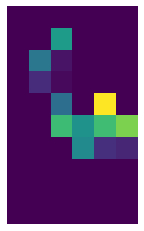

In [42]:
plot_heatmap(bin_firing_trial)

## Statistical Analyses

In [43]:
# Create shuffled time series for comparison
times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates)

## Compute Spatial Information

In [44]:
# Compute the spatial information
spike_info = compute_spatial_information(normed_bin_firing, occ)
print(spike_info)

2.0776243307767954


### Shuffle Comparisons

In [45]:
# Compute spatial information measures on surrogates
surrs = np.zeros(n_surrogates)
for ind, stimes in enumerate(times_shuffle):
    bin_firing = compute_place_bins(stimes, bins, ptimes, positions, x_bin_edges, y_bin_edges)
    surrs[ind] = compute_spatial_information(bin_firing, occ, normalize=True)

p-value: 0.90
z-score: -1.47


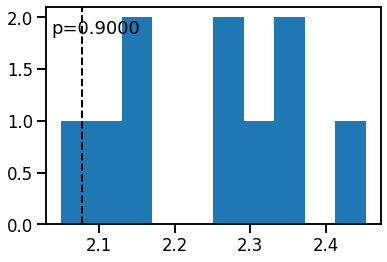

In [46]:
# Compute statistics on the surrogates
p_val, z_score = compute_surrogate_stats(spike_info, surrs)

## Compute ANOVA

In [47]:
# Collect place firing, organized per trial
place_trial = get_trial_place(spikes, nwbfile.trials, bins, ptimes, positions,
                              speed, x_bin_edges, y_bin_edges, occ_kwargs)

In [48]:
# Create the dataframe
df = create_df_place(place_trial, drop_na=True)

In [49]:
# Fit the ANOVA, and get the f-value
f_val = fit_anova_place(df)
f_val

1.49428299227364

### Shuffle Comparisons

In [50]:
# Create shuffles
times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates, **shuffle_kwargs)

In [51]:
# Compute measures on surrogates
surrogates = np.zeros(n_surrogates)
for ind, shuffle in enumerate(times_shuffle):
    place_trial = get_trial_place(shuffle, nwbfile.trials, bins, ptimes, positions,
                                  speed, x_bin_edges, y_bin_edges, occ_kwargs)
    df = create_df_place(place_trial)
    surrogates[ind] = fit_anova_place(df)

p-value: 0.00
z-score: 2.15


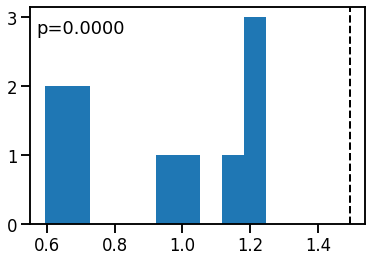

In [52]:
# Compute statistics on the surrogates
p_val, z_score = compute_surrogate_stats(f_val, surrogates)

## All Cells

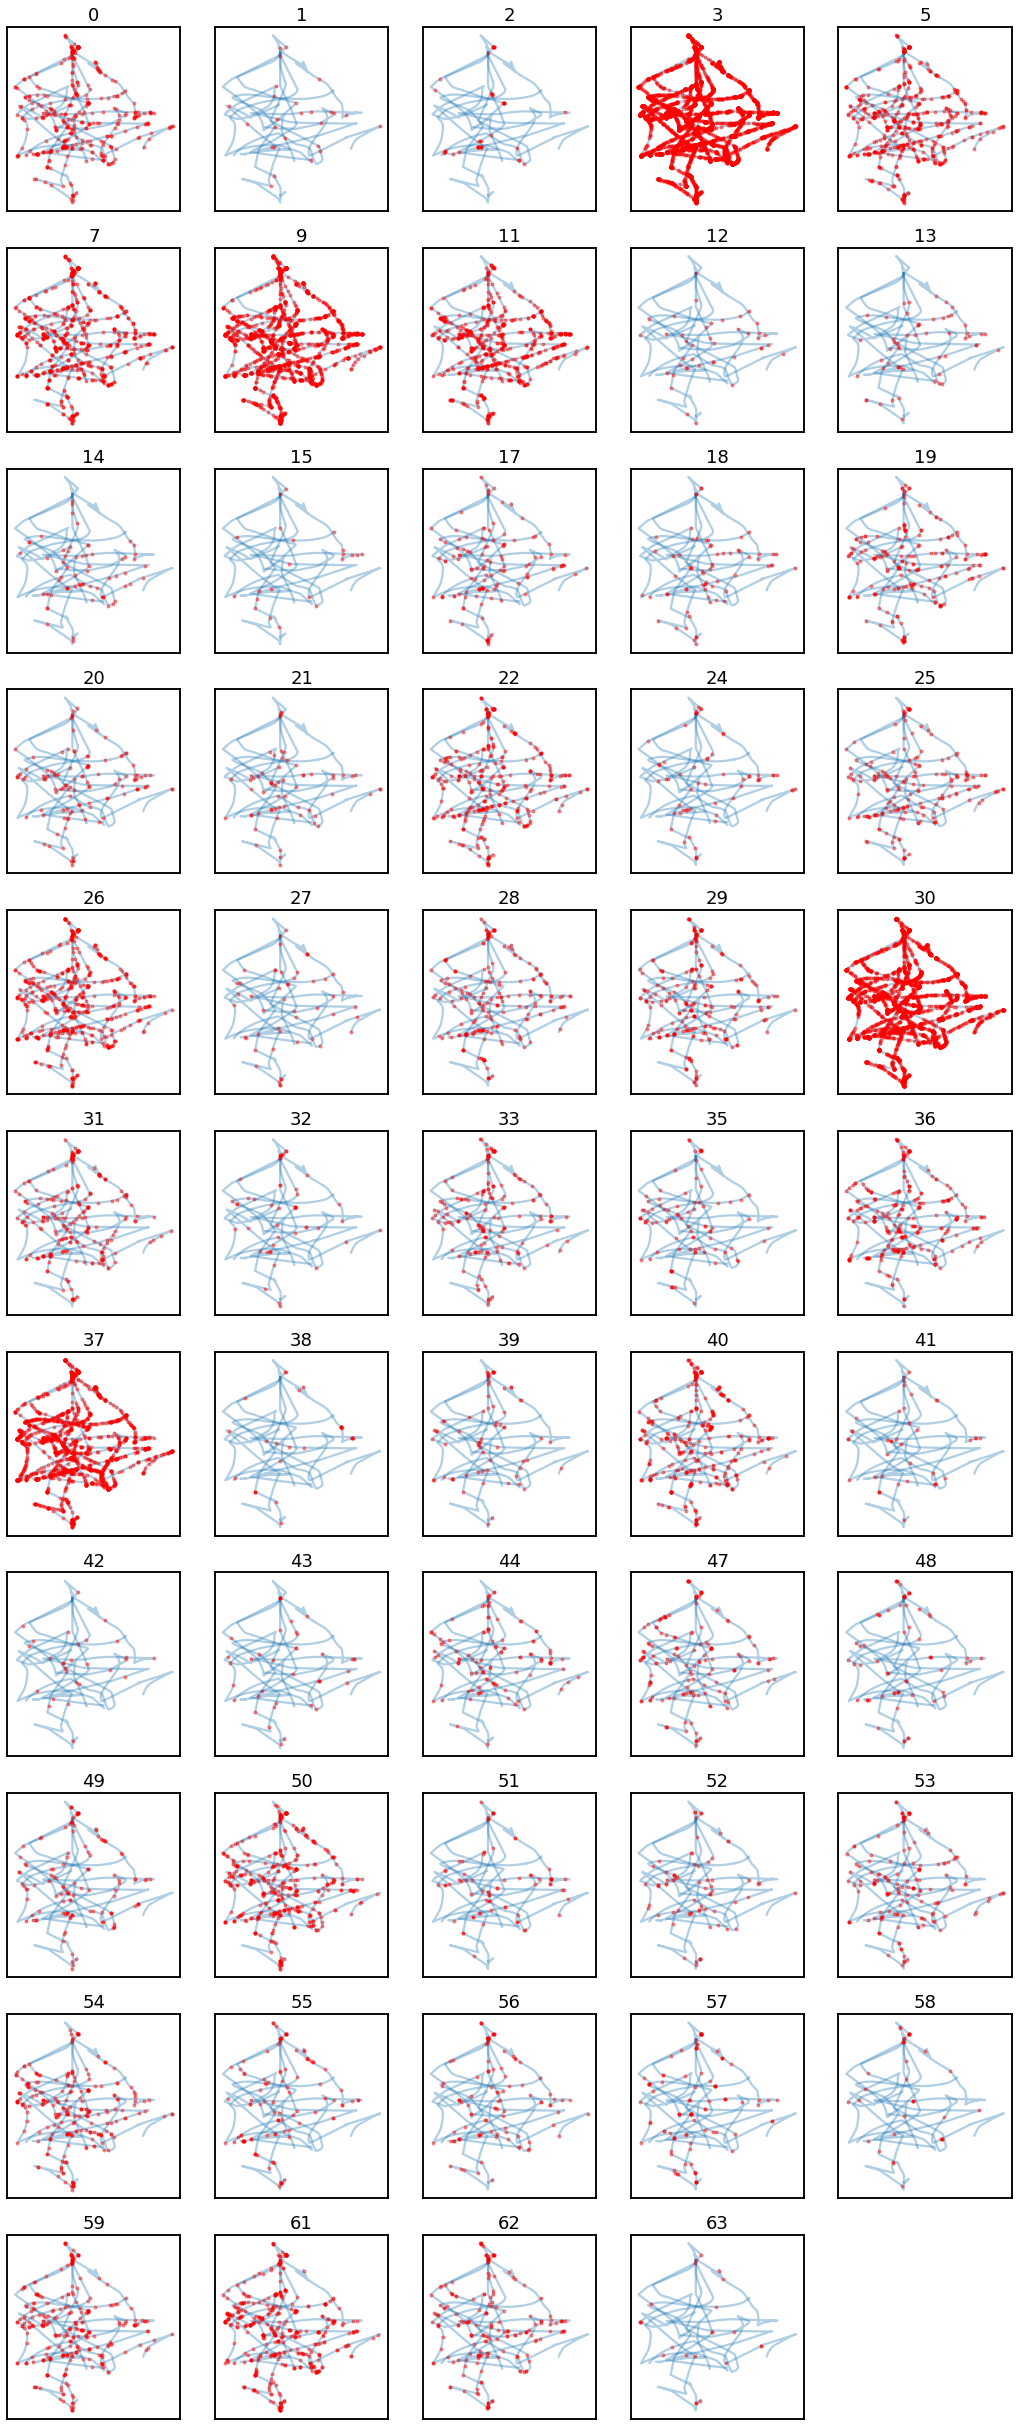

In [53]:
# Examine spatial firing across all cells
for ii, ax in zip(keep_inds, make_axes(n_keep)):
    
    spikes = nwbfile.units.get_unit_spike_times(ii)    
    spike_xs, spike_ys = get_spike_positions(spikes, ptimes, positions)
    
    plot_positions(positions_trials, np.array([spike_xs, spike_ys]), ax=ax)
    ax.set_title(ii)

In [54]:
# # Examine spatial firing across all cells
# for ii, ax in zip(keep_inds, make_axes(n_keep)):
    
#     spikes = nwbfile.units.get_unit_spike_times(ii)

#     # Compute real data value
#     if METHOD == 'INFO':
#         bin_firing = compute_place_bins(spikes, bins, ptimes, positions, x_bin_edges, y_bin_edges, occ)
#         data_value = compute_spatial_information(bf_data, occ, normalize=False)

#     if METHOD == 'ANOVA':
#         place_trial = get_trial_place(shuffle, nwbfile.trials, bins, ptimes, positions,
#                                       speed, x_bin_edges, y_bin_edges, occ_kwargs)
#         df = create_df_place(place_trial)
#         data_value = fit_anova_place(df)
        
#     surrogates = np.zeros(n_surrogates)
#     times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates, **shuffle_kwargs)
#     for ind, shuffle in enumerate(times_shuffle):
        
#         if METHOD == 'INFO':
#             bf_shuffle = compute_place_bins(shuffle, bins, ptimes, positions, x_bin_edges, y_bin_edges, occ)
#             surrogates[ind] = compute_spatial_information(bf_shuffle, occ, normalize=False)
        
#         if METHOD == 'ANOVA':
#             place_trial = get_trial_place(shuffle, nwbfile.trials, bins, ptimes, positions,
#                                           speed, x_bin_edges, y_bin_edges, occ_kwargs)
#             df = create_df_place(place_trial)
#             surrogates[ind] = fit_anova_place(df)
        
#     # Compute z-score & p-value based on surrogates
#     p_val, z_score = compute_surrogate_stats(data_value, surrogates, plot=False, verbose=False, ax=ax)    
    
#     # Plot occupancy-normalized spatial firing
#     plot_heatmap(bin_firing, ax=ax)
#     ax.set_title('U{} - ({:1.2f}-{:1.2f}) \n z-{:1.2f}, p-{:1.2f}'.format(\
#                      ii, *get_range(bin_firing), z_score, p_val),
#                  fontdict={'fontsize' : 12}, color=color_pval(p_val))